In [2]:
import xarray as xr
import pandas as pd

from functions import plot_params
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [48]:
# load the slocum data

sl_grid = xr.open_dataset('../../data/slocum/slocum_gridded.nc')
sl_xld = xr.open_dataset('../../data/slocum/slocum_xld.nc')
sl_eps = xr.open_dataset('../../data/slocum/slocum_epsilon.nc')
sl_sst = xr.open_dataset('../../data/slocum/slocum_sst_median_10m.nc')

wg = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/waveglider/WG_era5_1h_processed_28Aug2022.nc')

wg['dayofyear'] = (('date'), wg['dayofyear'].data)
wg = wg.sel(date=slice(wg.date[3], wg.date[-1]))

In [9]:
# cut the slocum data to meet the data length of the mixing layer depth

# sl_grid = sl_grid.sel(time=slice(xld.time[0].data, xld.time[-1].data))
# sl_sst = sl_sst.sel(time=slice(xld.time[0].data, xld.time[-1].data))

# sl_sst_6h = sl_sst.resample(time='6H').mean()
# sl_sst_1d = sl_sst.resample(time='1D').mean()

# xld_6h = xld.resample(time='6H').mean()

In [5]:
# load the ERA5 datasets

ds_era5_vars = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/ERA5/ds_era5_vars.nc').load()
ds_era5_flux = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/ERA5/ds_era5_flux.nc').load()

print('merging')

ds_era5_atl = xr.merge([ds_era5_vars, ds_era5_flux])

# process the ERA5 datasets

ds_era5_atl['sp'] = (('time', 'latitude', 'longitude'), ds_era5_atl['sp'].data/100)

ds_era5_atl['wnd'] = (('time', 'latitude', 'longitude'), np.sqrt(ds_era5_atl['u10']**2 + ds_era5_atl['v10']**2).data)

ds_era5_site = ds_era5_atl.sel(longitude=0, latitude=-54)

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

ds_era5_site['DOY']=(('time'), mdates.date2num(ds_era5_site.time)-day0)

ds_era5_site = ds_era5_site.sel(time=slice(sl_xld.time.data[0], sl_xld.time.data[-1]))

ds_era5_site['qnet'] = (('time'), ds_era5_site['sshf'].data + ds_era5_site['slhf'].data + ds_era5_site['str'].data + ds_era5_site['ssr'].data)

ds_era5_site['sthf'] = (('time'), ds_era5_site.sshf.data + ds_era5_site.slhf.data)

import functions.dewpoint_to_rh as dp2rh

ds_era5_site = dp2rh.convert_dp_to_rh(ds_era5_site)

ds_era5_site['dt'] = (('time'), ds_era5_site['t2m'].data - ds_era5_site['sst'].data)

merging


In [51]:
# identify storms from the ERA5 wind speeds

def id_storms(ds, wind_var='ws'):

    # Identify storms by taking the wind speed as 10 m/s or larger for 8 hours or more

    storm_locs = np.arange(ds.time.size)[ds[wind_var]>10]  # Find the indices where wind speed is greater than 10 m/s

    # Finding consecutive groups

    consecutive_storm_locs = np.split(storm_locs, np.where(np.diff(storm_locs) != 1)[0] + 1)  # Split the indices into groups where consecutive indices differ by 1

    # Merging groups with a difference of two or less indices

    merged_groups = [consecutive_storm_locs[0]]  # Initialize with the first group

    for group in consecutive_storm_locs[1:]:
        if group[0] - merged_groups[-1][-1] <= 8:  # If the difference between the first index of the current group and the last index of the last group is less than or equal to 8
            merged_groups[-1] = np.concatenate((merged_groups[-1], group))  # Merge the current group with the last group
        else:
            merged_groups.append(group)  # Otherwise, add the current group as a new group

    merged_storms = []
    
    for i in range(len(merged_groups)):
        if len(merged_groups[i]) > 12:  # If the length of the group is greater than 12
            merged_storms.append(merged_groups[i])  # Add the group to the list of merged storms

    # Append the indices of the merged storms to the storms_idx array

    storms_idx = np.array([])

    for s in range(len(merged_storms)):
        storms_idx = np.append(storms_idx, merged_storms[s])  

    # Initialize an array of zeros with the same size as the time dimension

        storms = np.zeros(ds.time.size)  

# Set the indices corresponding to storms to 1

    storms[storms_idx.astype(int)]=1  

    # Add the storms array to the dataset as a new variable

    ds['storms'] = (('time'), storms)  

    ds['storms'].attrs['long_name'] = 'Boolean value for the presence of storm conditions (>10 m/s winds for 8 consecutive hours). 0 = non storm, 1 = storm.'  # Add a long_name attribute to the storms variable

    return ds, merged_storms

ds_era5_site, merged_storms = id_storms(ds_era5_site, wind_var='wnd')

ds_storms = ds_era5_site.isel(time=ds_era5_site.storms==1)  # Select the times when storms are present
ds_non_storms = ds_era5_site.isel(time=ds_era5_site.storms==0)  # Select the times when storms are not present


In [16]:
print('Storm hours:', ds_storms.time.size)
print('Non-storm hours:', ds_non_storms.time.size)

total_hours = ds_storms.time.size + ds_non_storms.time.size

print('Storm %:', 100*ds_storms.time.size/total_hours)

Storm hours: 940
Non-storm hours: 944
Storm %: 49.89384288747346


In [44]:
# CHANGE THE DATES FOR THE WAVE GLIDER AND ERA5 WINDS

u10_era5 = ds_era5_site.sel(time=slice(wg.date[0], wg.date[-1]))

In [24]:
# resize the wave glider dataset and find the correlation to the era5 winds

wg = wg.sel(dayofyear=slice(wg.dayofyear[3], wg.dayofyear[-1]))

idx = ~np.isnan(wg['WindSpeed_ms_10m'])

print('corr', np.corrcoef(wg['WindSpeed_ms_10m'].data[idx], u10_era5.wnd.data[idx])[0,1]**2)

print('rmse', np.mean(wg['WindSpeed_ms_10m'].data[idx] - u10_era5.wnd.data[idx]))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
corr 0.8040850798033182
rmse 1.2256678994637882


In [19]:
# CALCULATE THE MIXED LAYER HEAT BUDGET

In [25]:
# entrainment term:

# find the temperature difference between the MLD and 10 m below the MLD

depth = 5

dT = np.ndarray(sl_grid.mld_t.size)

for i, mld in enumerate(sl_grid.mld_t):

    try: 
        mld_int = mld.data.astype(int)

        mld_int = mld.data.astype(int) + depth

        t_mld = sl_grid.temperature[mld_int-5, i]
        t_mld_depth = sl_grid.temperature[mld_int+depth, i]

        dT[i] = t_mld - t_mld_depth

    except:
        dT[i] = np.nan

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int) + depth
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int) + depth
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_86503/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.

In [27]:
from scipy.interpolate import griddata

# grid the mixed layer depth and delta temperature to 1 hour time steps

mld_1hr = griddata(sl_grid.DOY, sl_grid.mld_t, ds_era5_site.DOY) # grid the mld to 1 hour
dT_1hr = griddata(sl_grid.DOY, dT, ds_era5_site.DOY) # grid the temperature difference between the MLD and 10 m below the base to 1 hour

from scipy.ndimage import uniform_filter1d

# Apply a smoothing window on the MLD and dT
import glidertools as gt

mld_1hr_smooth = gt.cleaning.rolling_window(mld_1hr,np.nanmean,24)
dT_1hr_smooth = gt.cleaning.rolling_window(dT_1hr,np.nanmean,6)

dmld_dt = np.gradient(mld_1hr_smooth)/3600 # mld difference in meters per second
dmld_dt = np.append(np.array(0), np.diff(mld_1hr_smooth))/3600 # mld difference in meters per second


dmld_dt[dmld_dt<0]=0 # if the mld is shoaling, make the entrainment velocity zero


/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/glidertools/helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [28]:
# calculate the entrainment term

entrainment_dT = (dT_1hr_smooth*dmld_dt)/mld_1hr_smooth

In [30]:
# heat flux term:

heat_flux_dT = ds_era5_site.qnet/(1027*4000*mld_1hr)


In [31]:
# determine the projected sst from the heat flux term and entrainment

proj_sst_heat_flux = 3600*np.cumsum(heat_flux_dT)
proj_sst_entrainment = -3600*np.nancumsum(entrainment_dT)

proj_sst_net = proj_sst_heat_flux + proj_sst_entrainment

ds_era5_site['proj_sst_net'] = (('time'), proj_sst_net.data)

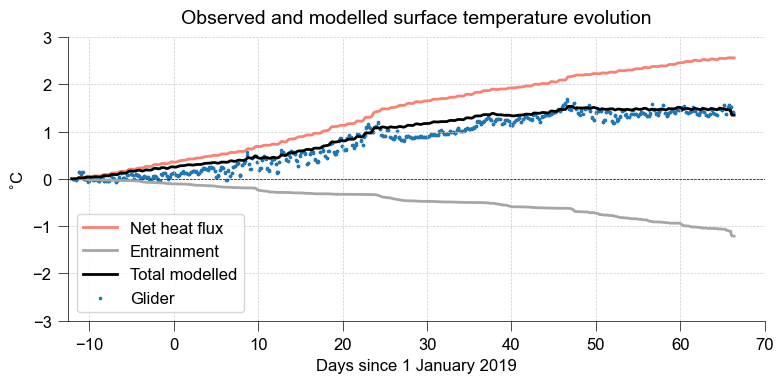

In [69]:
fig, ax = plt.subplots(figsize=(8,4))

ax.axhline(c='k', lw=0.5, ls='--')

# plot the individual terms
ax.plot(ds_era5_site.DOY, proj_sst_heat_flux, label='Net heat flux', lw=2, c='salmon')
ax.plot(ds_era5_site.DOY, proj_sst_entrainment, label='Entrainment', lw=2, c='0.65')

# plot the net modelled sst
ax.plot(ds_era5_site.DOY, ds_era5_site.proj_sst_net, label='Total modelled', lw=2, c='k')

# glider observations
ax.scatter(sl_sst.DOY, sl_sst.sst-0.6, s=10, marker='.', label='Glider')

ax.set_xlim(-12.5, 70)
ax.set_ylim(-3, 3)

ax.legend(loc=3)

ax.set_xlabel('Days since 1 January 2019')
ax.set_ylabel('$^{\circ}$C')

ax.grid(ls='--', c='0.8', lw=0.5)

ax.set_title('Observed and modelled surface temperature evolution', fontsize=14, pad=10)

fig.tight_layout()

plt.savefig('../../figs/ext-data-figure-2a.png', dpi=600)

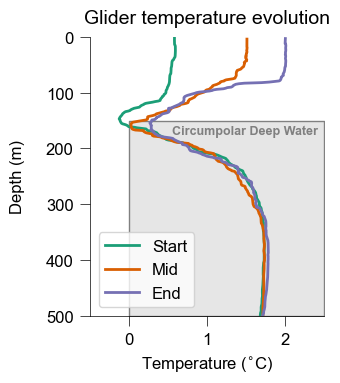

In [71]:
# PLOT BEGINNING, MID-POINT, AND END TEMP PROFILES

# PEDRO COMMENT: can you show temp profiles at beginning, mid point and end? 
# at the observation location the CDW temperature should be approx 2oC.  
# So the question is whether entrainment is cooling or warming?  
# also what is the role of salinity in N2?

# choosing colorblind friendly colors: https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
color1='#1b9e77'
color2='#d95f02'
color3='#7570b3'

fig, ax = plt.subplots(figsize=(3.5,4))

ax.plot(sl_grid.temperature.isel(time=5),   sl_grid.depth, c=color1, lw=2, label='Start')
ax.plot(sl_grid.temperature.isel(time=380), sl_grid.depth, c=color2, lw=2, label='Mid')
ax.plot(sl_grid.temperature.isel(time=760), sl_grid.depth, c=color3, lw=2, label='End')

ax.fill_betweenx(x1=0, x2=2.5, y=[150, 500], facecolor='0.9', edgecolor='0.5')

ax.text(0.55, 175, 'Circumpolar Deep Water', fontweight='bold', c='0.5', fontsize=9)

ax.invert_yaxis()
ax.legend()

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(500, 0)

ax.set_ylabel('Depth (m)', labelpad=15)
ax.set_xlabel('Temperature ($^{\circ}$C)')

ax.set_title('Glider temperature evolution', fontsize=14, pad=10)

fig.tight_layout()

plt.savefig('../../figs/ext-data-figure-2b.png', dpi=300)


In [33]:
# calcualte daily mean of the ERA5 variables

ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()
ds_era5_site_1D = ds_era5_site_1D.isel(time=np.arange(ds_era5_site_1D.time.size)[1:])

# and the sst

sl_sst_1d = sl_sst.resample(time='1D').mean()

In [34]:
# correlation of the SST between the observed daily average and projected

np.corrcoef(sl_sst_1d.sst, ds_era5_site_1D.proj_sst_net)**2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([[1.        , 0.97788983],
       [0.97788983, 1.        ]])

In [36]:
# calculate the buoyancy fluxes

import gsw

g = -9.81
alpha = gsw.alpha(34, ds_era5_site.sst, p=0)
rho = 1027
cp = 4000

ds_era5_site['Bo'] = -(g*alpha*ds_era5_site.qnet)/(rho*cp)

ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()

In [37]:
# figure 2a

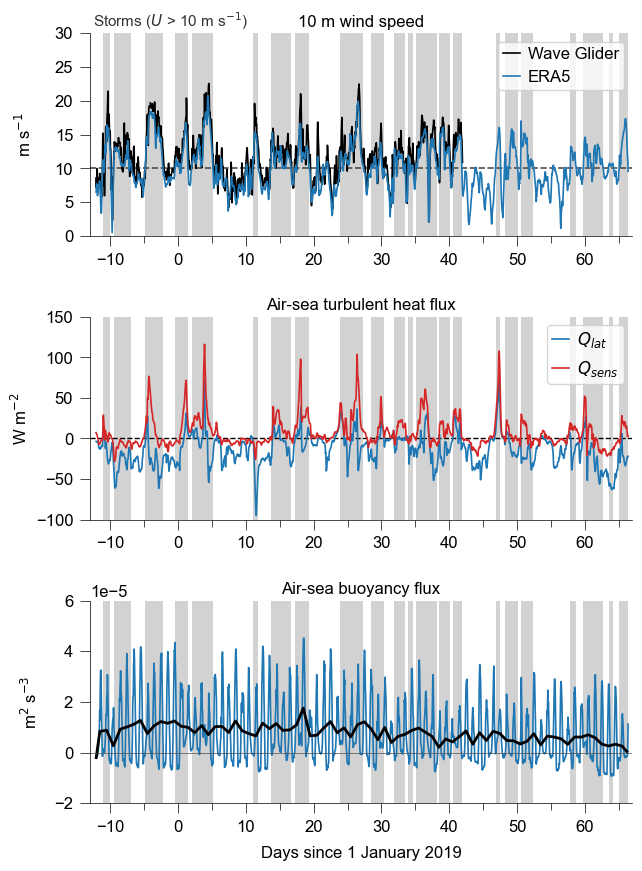

In [53]:
# PLOT THE OBSERVATIONAL SECTIONS FIRST PART

fig,ax=plt.subplots(3, figsize=(7,10))

fig.subplots_adjust(hspace=0.4)

ax[0].plot(wg['dayofyear'], wg['WindSpeed_ms_10m'], c='k', label='Wave Glider')

ax[0].plot(ds_era5_site.DOY, ds_era5_site.wnd, label='ERA5')
ax[0].axhline(10, c='0.3', ls='--', zorder=1)

ax[1].plot(ds_era5_site.DOY, ds_era5_site.slhf, label='$Q_{lat}$')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf, label='$Q_{sens}$', c='tab:red')

ax[2].plot(ds_era5_site.DOY, ds_era5_site.Bo)
ax[2].plot(ds_era5_site_1D.DOY, ds_era5_site_1D.Bo, c='k', lw=2)
ax[2].axhline(0, c='0.3', lw=0.5)

ax[0].set_ylim(0, 30)
ax[1].set_ylim(-100, 150)
ax[2].set_ylim(-2e-5, 6e-5)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):

        start = merged_storms[s][0]
        end = merged_storms[s][-1]
        
        a.fill_betweenx(y=[-200, 1000], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0)        

ax[0].set_ylabel('m s$^{-1}$', labelpad=15)
ax[1].set_ylabel('W m$^{-2}$')
ax[2].set_ylabel('m$^2$ s$^{-3}$', labelpad=10)

ax[0].yaxis.set_ticks(np.arange(0, 35, 5))
ax[1].yaxis.set_ticks(np.arange(-100, 200, 50))

ax[1].axhline(0, c='k', lw=1, ls='--', zorder=0)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, ncol=1, frameon=True)
ax[1].legend(loc=1, bbox_to_anchor=(1, 1), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, ncol=1, frameon=True)

ax[2].set_xlabel('Days since 1 January 2019', labelpad=8)

ax[2].text(32, 230, '')

ax[0].text(-12.5, 31, 'Storms ($U$ > 10 m s$^{-1}$)', c='0.2', fontsize=11)

bbox_props = dict(boxstyle="round,pad=0.3", fc="0.95", ec="black", lw=1)

#ax[0].text(25, 27.5, '10m wind speed', ha="center", va="center", bbox=bbox_props)
#ax[1].text(25, 127.5, 'Air-sea turbulent heat flux', ha="center", va="center", bbox=bbox_props)
#ax[2].text(25, 180, 'Dissipation', ha="center", va="center", bbox=bbox_props)

ax[0].set_title('10 m wind speed', fontsize=12, pad=5)
ax[1].set_title('Air-sea turbulent heat flux', fontsize=12, pad=5)
ax[2].set_title('Air-sea buoyancy flux', fontsize=12, pad=5)

# fig.tight_layout()

plt.savefig('../../figs/figure_2a.png', dpi=600)

In [58]:
# perfirm a running mean of the stratification array

N2_rm = np.ndarray(sl_grid.N2.shape)
N2_S_rm = np.ndarray(sl_grid.N2.shape)
N2_T_rm = np.ndarray(sl_grid.N2.shape)

window_size = 20

for i in range(sl_grid.time.size):

    N2_series = pd.Series(sl_grid.N2.isel(time=i))
    N2_S_series = pd.Series(sl_grid.N2_S.isel(time=i))
    N2_T_series = pd.Series(sl_grid.N2_T.isel(time=i))

    N2_rm[:,i]   = N2_series.rolling(window=window_size, min_periods=5, center=True).mean()
    N2_S_rm[:,i] = N2_S_series.rolling(window=window_size, min_periods=5, center=True).mean()
    N2_T_rm[:,i] = N2_T_series.rolling(window=window_size, min_periods=5, center=True).mean()

sl_grid['N2_rm'] = (('depth', 'time'), N2_rm)
sl_grid['N2_S_rm'] = (('depth', 'time'), N2_S_rm)
sl_grid['N2_T_rm'] = (('depth', 'time'), N2_T_rm)

In [59]:
# a function to calculate and plot the rate of warming during the four warming periods

from scipy import stats

def plot_reg(x,y,doy_min,doy_max,ax,color,label=False):
    
    idx = (x > doy_min) & (x < doy_max)
    
    x_subset = x.isel(time=idx)
    y_subset = y.isel(time=idx)
    
    # Create a linear regression model
    res = stats.linregress(x_subset, y_subset)
    
    print(f"R-squared: {res.rvalue**2:.6f}")
    print('degC/day:', res.slope)
    
    #ax.plot(x, y, 'o', label='original data')

    if label == True:
        ax.plot(x_subset, res.intercept + res.slope*x_subset, c=color, label='Period regression', lw=2, ls='--')

    else:
        ax.plot(x_subset, res.intercept + res.slope*x_subset, c=color, lw=2, ls='--')

    return

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.488996
degC/day: 0.011614003356729147
R-squared: 0.762112
degC/day: 0.04273472505728037
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.811292
degC/day: 0.02715779857902756
R-squared: 0.040485
degC/day: 0.0029952740927635195
Intel MKL WARNING: Support of Intel(R) Streamin

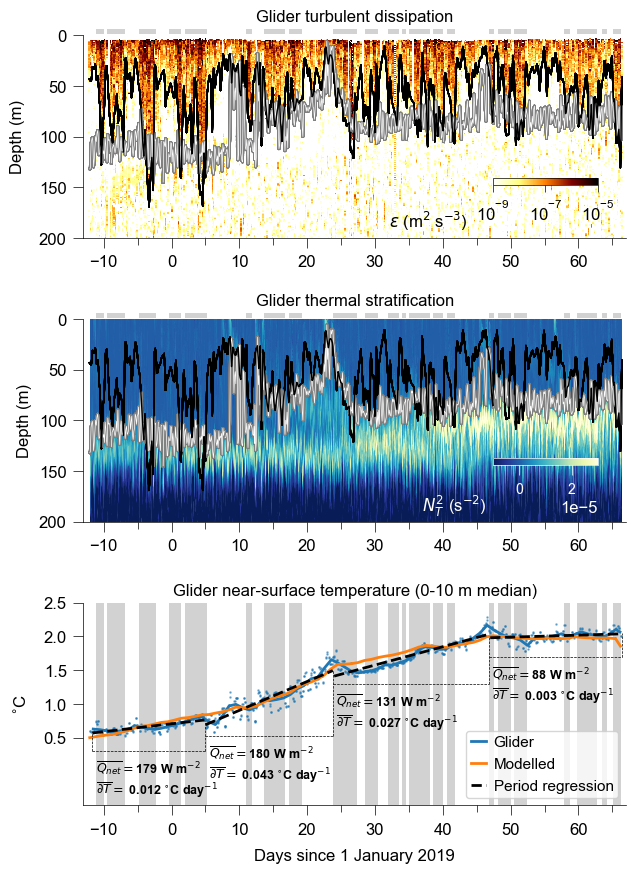

In [61]:
fig,ax=plt.subplots(3, figsize=(7,10))

fig.subplots_adjust(hspace=0.4)

img_ep = ax[0].pcolormesh(sl_eps.DOY, sl_eps.DEPTH, sl_eps.EPS_FINAL, norm=LogNorm(vmin=10e-10, vmax=10e-6), cmap='afmhot_r', shading='auto')

caxis = fig.add_axes([0.71, 0.73, 0.15, 0.0075])
cb = fig.colorbar(mappable=img_ep, cax=caxis, orientation='horizontal')
cb.outline.set_edgecolor('k')  # Color of colorbar box
cb.ax.xaxis.set_tick_params(color='k', labelcolor='k', labelsize=12, length=5)  # Color of ticks

img_st = ax[1].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.N2_T_rm.interpolate_na(dim='time'), vmin=-1e-5, vmax=3e-5, cmap='YlGnBu_r')

caxis = fig.add_axes([0.71, 0.45, 0.15, 0.0075])
cb = fig.colorbar(mappable=img_st, cax=caxis, orientation='horizontal')
cb.outline.set_edgecolor('white')  # Color of colorbar box
cb.ax.xaxis.set_tick_params(color='white', labelcolor='white', labelsize=10)  # Color of ticks

ax[2].plot(sl_sst_1d.DOY, sl_sst_1d.sst, c='tab:blue', lw=2, label='Glider')

ax[2].scatter(sl_sst.DOY, sl_sst.sst, s=3, marker='.', alpha=0.5)

# plot the projected sst

ax[2].plot(ds_era5_site_1D.DOY, ds_era5_site_1D.proj_sst_net+0.5, label='Modelled', c='tab:orange', lw=2)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):
        
        start = merged_storms[s][0]
        end = merged_storms[s][-1]

        if i==2:
            a.fill_betweenx(y=[-200, 1000], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0)
        else:
            a.fill_betweenx(y=[-6, -1], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0, clip_on=False)     
            a.plot(sl_grid.DOY, sl_grid.mld_t-10, c='0.5', lw=2, ls='-')
            a.plot(sl_grid.DOY, sl_grid.mld_t-10, c='w', lw=0.5, ls='-')
            a.plot(sl_xld.DOY, sl_xld.xld, c='k', lw=1)  
            a.set_ylim(200, 0)  

ax[0].set_ylabel('Depth (m)', labelpad=10)
ax[1].set_ylabel('Depth (m)', labelpad=5)
ax[2].set_ylabel('$^{\circ}$C', labelpad=10)

ax[2].set_ylim(-0.5, 2.5)
ax[2].yaxis.set_ticks(np.arange(0.5, 3, 0.5))

ax[2].set_xlabel('Days since 1 January 2019', labelpad=8)

x1 = -11.7
x2 = 5
x3 = 23.8
x4 = 46.8
x5 = 66.5

y1 = 0.3
y2 = 0.525 
y3 = 1.3
y4 = 1.7

ax[2].plot([x1, x2], [y1, y1], c='k', lw=0.5, ls='--')
ax[2].plot([x2, x3], [y2, y2], c='k', lw=0.5, ls='--')
ax[2].plot([x3, x4], [y3, y3], c='k', lw=0.5, ls='--')
ax[2].plot([x4, x5], [y4, y4], c='k', lw=0.5, ls='--')

x = sl_sst.DOY
y = sl_sst.sst

plot_reg(x,y,x1,x2,ax[2], color='k')
plot_reg(x,y,x2,x3,ax[2], color='k')
plot_reg(x,y,x3,x4,ax[2], color='k')
plot_reg(x,y,x4,x5,ax[2], color='k', label=True)

x = ds_era5_site.DOY
y = ds_era5_site['proj_sst_net'] + 0.6

# legend

ax[2].legend(ncol=1, loc=4, bbox_to_anchor=(1.0, 0.0), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=11, frameon=True)

props = dict(fontsize=9, fontweight='bold')

y_offset = 0.32
x_offset = 0.5

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x1) & (ds_era5_site.DOY < x2))).qnet.mean(dim='time').data)
ax[2].text(x1 + x_offset, y1 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x2) & (ds_era5_site.DOY < x3))).qnet.mean(dim='time').data)
ax[2].text(x2 + x_offset, y2 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x3) & (ds_era5_site.DOY < x4))).qnet.mean(dim='time').data)
ax[2].text(x3 + x_offset, y3 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x4) & (ds_era5_site.DOY < x5))).qnet.mean(dim='time').data)
ax[2].text(x4 + x_offset, y4 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

# mean warming rate

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x1) & (sl_sst_1d.DOY < x2))).sst.diff(dim='time').mean(dim='time').data, 3)
# ax[2].text(x1 + x_offset, y1 + y_offset, r'$\overline{\partial T} = $' + str(dt_mean) + ' $^{\circ}$C day$^{-1}$', **props)
ax[2].text(x1 + x_offset, y1 - y_offset-0.32, r'$\overline{\partial T} = $ 0.012 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x2) & (sl_sst_1d.DOY < x3))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x2 + x_offset, y2 - y_offset-0.32, r'$\overline{\partial T} = $ 0.043 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x3) & (sl_sst_1d.DOY < x4))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x3 + x_offset, y3 - y_offset-0.32, r'$\overline{\partial T} = $ 0.027 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x4) & (sl_sst_1d.DOY < x5))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x4 + x_offset, y4 - y_offset-0.32, r'$\overline{\partial T} = $ 0.003 $^{\circ}$C day$^{-1}$', **props)

ax[0].set_title('Glider turbulent dissipation', fontsize=12, pad=10)
ax[1].set_title('Glider thermal stratification', fontsize=12, pad=10)
ax[2].set_title('Glider near-surface temperature (0-10 m median)', fontsize=12, pad=5)

ax[0].text(32, 190, '$\epsilon$ (m$^2$ s$^{-3}$)')
ax[1].text(37, 190, '$N_T^2$ (s$^{-2}$)', c='white')

ax[2].plot([x1, x1], [y1, 0.60], c='k', lw=0.5, ls='--')
ax[2].plot([x2, x2], [y1, 0.75], c='k', lw=0.5, ls='--')
ax[2].plot([x3, x3], [y2, 1.49], c='k', lw=0.5, ls='--')
ax[2].plot([x4, x4], [y3, 2.00], c='k', lw=0.5, ls='--')
ax[2].plot([x5, x5], [y4, 2.05], c='k', lw=0.5, ls='--')

plt.savefig('../../figs/figure_2b.png', dpi=300)

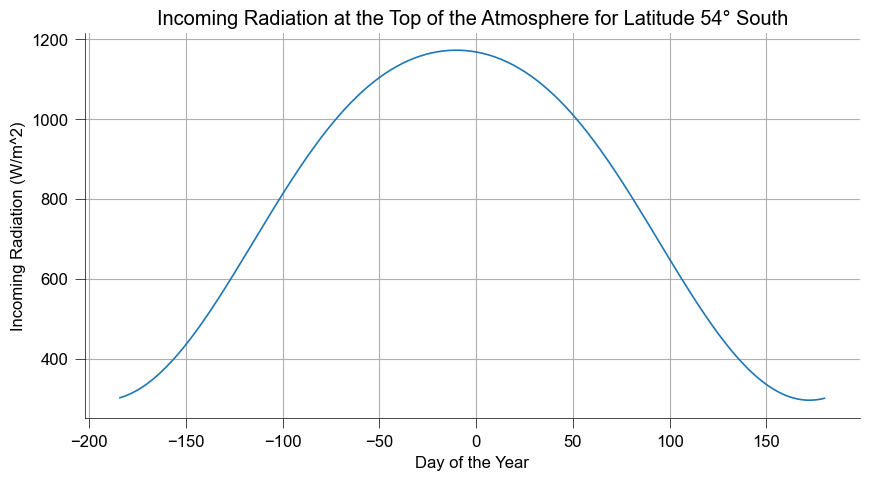

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the solar constant (in W/m^2)
solar_constant = 1361

# Define the latitude (in degrees)
latitude_deg = -54  # Negative for southern hemisphere

# Convert the latitude to radians
latitude_rad = np.radians(latitude_deg)

# Create an array for the day of the year
day_of_year = np.arange(1, 366)

# Calculate the declination angle (in degrees)
declination_angle_deg = 23.45 * np.sin((2 * np.pi / 365.0) * (day_of_year - 81))

# Convert the declination angle to radians
declination_angle_rad = np.radians(declination_angle_deg)

# Calculate the solar elevation angle at solar noon (in radians)
solar_elevation_angle_rad = np.arcsin(np.sin(latitude_rad) * np.sin(declination_angle_rad) + np.cos(latitude_rad) * np.cos(declination_angle_rad))

# Calculate the incoming radiation at the top of the atmosphere (in W/m^2)
incoming_radiation = solar_constant * np.sin(solar_elevation_angle_rad)

# sort it so that it fits the date format
day_of_year[day_of_year>180] = day_of_year[day_of_year>180] - 365
idx = np.argsort(day_of_year)

day_of_year = day_of_year[idx]
incoming_radiation = incoming_radiation[idx]

# Plot the incoming radiation as a function of day of the year
plt.figure(figsize=(10, 5))
plt.plot(day_of_year, incoming_radiation)
plt.xlabel('Day of the Year')
plt.ylabel('Incoming Radiation (W/m^2)')
plt.title('Incoming Radiation at the Top of the Atmosphere for Latitude 54° South')
plt.grid(True)
plt.show()


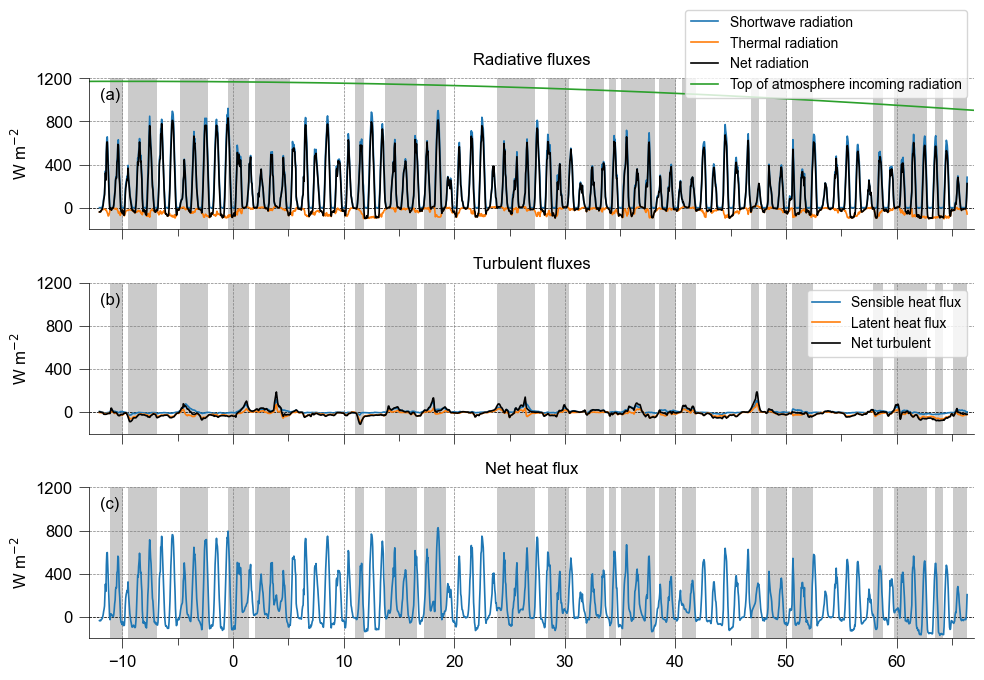

In [38]:
# plot the heat flux time series

fig, ax = plt.subplots(3, figsize=(10,7), sharex=True)

for a in ax:
    a.axhline(c='k', lw=0.5, ls='--')
    a.grid(lw=0.5, c='0.5', ls='--')
    a.set_ylabel('W m$^{-2}$')

ax[0].plot(ds_era5_site.DOY, ds_era5_site.ssr, label='Shortwave radiation')
ax[0].plot(ds_era5_site.DOY, ds_era5_site.str, label='Thermal radiation')
ax[0].plot(ds_era5_site.DOY, ds_era5_site.str+ds_era5_site.ssr, label='Net radiation', c='k')
ax[0].plot(day_of_year, incoming_radiation, label='Top of atmosphere incoming radiation')

ax[0].legend(bbox_to_anchor=(1.0, 1.5), loc=1, fontsize=10)

ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf, label='Sensible heat flux')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.slhf, label='Latent heat flux')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf+ds_era5_site.slhf, label='Net turbulent', c='k')

ax[1].legend(fontsize=10)

ax[2].plot(ds_era5_site.DOY, ds_era5_site.qnet)

ax[0].set_ylim(-200, 1200)
ax[1].set_ylim(-200, 1200)
ax[2].set_ylim(-200, 1200)

ax[0].set_title('Radiative fluxes', fontsize=12, pad=10)
ax[1].set_title('Turbulent fluxes', fontsize=12, pad=10)
ax[2].set_title('Net heat flux', fontsize=12, pad=10)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.yaxis.set_ticks(np.arange(0, 1600, 400))

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):
        
        start = merged_storms[s][0]
        end = merged_storms[s][-1]

        a.fill_betweenx(y=[-200, 1200], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.6', alpha=0.5, zorder=0)

ax[0].text(-12, 1000, '(a)')
ax[1].text(-12, 1000, '(b)')
ax[2].text(-12, 1000, '(c)')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/heat_fluxes.png', dpi=600)

In [ ]:
# extended data figure 3

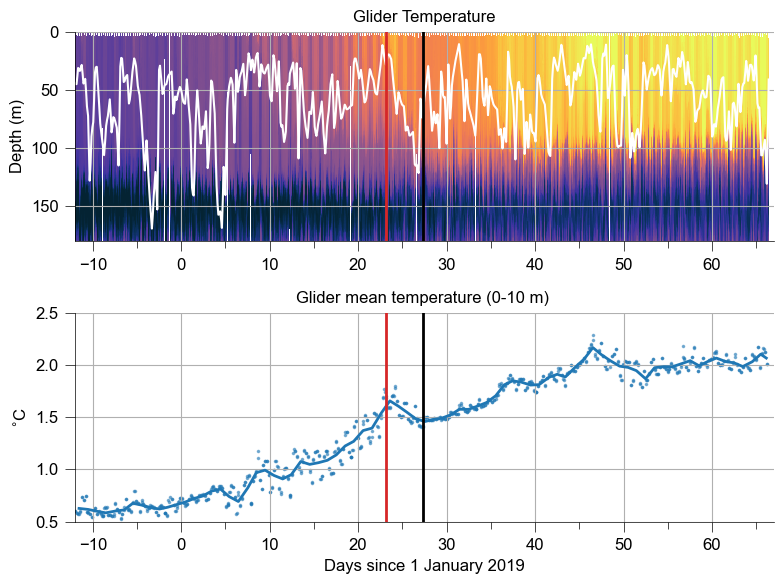

In [64]:
fig,ax = plt.subplots(2, figsize=(8,6))

ax[0].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.temperature, cmap=cmo.thermal, vmin=0, vmax=2.1)
ax[0].set_ylim(180, 0)
ax[0].plot(sl_xld.DOY, sl_xld.xld, c='w', lw=1.5)

ax[1].plot(sl_sst_1d.DOY, sl_sst_1d.sst, c='tab:blue', lw=2, label='Glider')
ax[1].scatter(sl_sst.DOY, sl_sst.sst, s=10, marker='.', alpha=0.5)

for a in ax:
    a.grid()
    a.set_xlim(-12, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

ax[1].set_ylim(0.5, 2.5)

doy=[23.2,27.3]

for a in ax:
    a.axvline(doy[0], c='tab:red', lw=2)
    a.axvline(doy[1], c='k', lw=2)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('$^{\circ}$C')

ax[0].set_title('Glider Temperature', fontsize=12, pad=7)
ax[1].set_title('Glider mean temperature (0-10 m) ', fontsize=12, pad=7)

ax[1].set_xlabel('Days since 1 January 2019')

fig.tight_layout()

plt.savefig('../../figs/ext-data-figure-3a.png', dpi=600)

In [41]:
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True

mean temp before:  0.9831140518288258
mean temp after:  1.0155893147124282


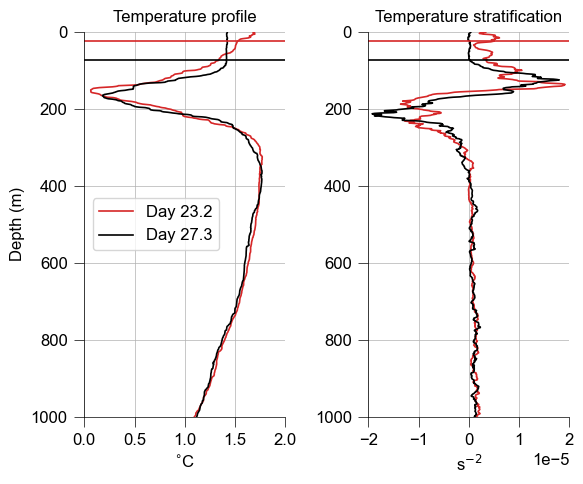

In [67]:
doy=[23.2,27.3]

fig,ax=plt.subplots(1,2,figsize=(6, 5))

before_i = np.argmin(np.abs(sl_grid.DOY.values-doy[0]))
after_i = np.argmin(np.abs(sl_grid.DOY.values-doy[1]))

ax[0].plot(sl_grid.isel(time=before_i).temperature, sl_grid.depth, c='tab:red', label='Day 23.2')
ax[0].plot(sl_grid.isel(time=after_i).temperature, sl_grid.depth, c='k', label='Day 27.3')

ax[0].legend()

ax[1].plot(sl_grid.isel(time=before_i).N2_T_rm, sl_grid.depth, c='tab:red')
ax[1].plot(sl_grid.isel(time=after_i).N2_T_rm, sl_grid.depth, c='k')

print('mean temp before: ', sl_grid.isel(time=before_i).temperature.sel(depth=slice(0,200)).mean().values)
print('mean temp after: ', sl_grid.isel(time=after_i).temperature.sel(depth=slice(0,200)).mean().values)

before_i_xld = np.argmin(np.abs(sl_xld.DOY.values-doy[0]))
after_i_xld = np.argmin(np.abs(sl_xld.DOY.values-doy[1]))

for a in ax:
    a.invert_yaxis()
    a.set_ylim(1000, 0)
    a.axhline(sl_xld.isel(time=before_i_xld).xld, c='tab:red')
    a.axhline(sl_xld.isel(time=after_i_xld).xld, c='k')
    a.grid(lw=0.5)

fig.tight_layout()

import gsw

lat_before = sl_grid.isel(time=before_i).latitude
lon_before = sl_grid.isel(time=before_i).longitude

lat_after = sl_grid.isel(time=after_i).latitude
lon_after = sl_grid.isel(time=after_i).longitude

gsw.distance([lon_before, lon_after], [lat_before, lat_after])

ax[0].set_xlim(0, 2)
ax[1].set_xlim(-2e-5, 2e-5)

ax[0].set_title('Temperature profile', fontsize=12, pad=7)
ax[1].set_title('Temperature stratification', fontsize=12, pad=7)

ax[0].set_ylabel('Depth (m)')

ax[0].set_xlabel('$^{\circ}$C')
ax[1].set_xlabel('s$^{-2}$')

fig.tight_layout()

plt.savefig('../../figs/ext-data-figure-3b.png', dpi=600)
